# Solving a Partial Differential Equation (PDEs) using a Physics-Informed Neural Network (PINN)
Let's solve the following ODE as an example:

$$-\frac{d^2u}{dx^2} = f(x), \quad x \in (0,1)$$​
$$ u = 0, \quad x = 0\ \&\ x=1 $$​



This is an exponential decay problem, whose solution is
$$u = \sin(\pi x)$$
$$f = \pi^2 \sin(\pi x)$$


**Step 1: Define the Neural Network**

Create a neural network that takes temporal coordinates as inputs and outputs the solution to the PDE at those points. Ensure that the network has enough capacity (layers and neurons) to capture the complexity of the solution.

In [1]:
import torch
import torch.nn as nn

class PDE_Net(nn.Module):
    def __init__(self):
        super(PDE_Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.net(x)


**Step 2: Define the Loss Function for the PDE**

The loss function should include the PDE's residual (the difference between the left-hand side and right-hand side of the PDE).

In [2]:
def eval_loss_pde(u_pred, x, f):

    # dudx = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    # d2udxx = torch.autograd.grad(dudx, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]

    dudx = (1+u_pred**2)*torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    d2udxx = torch.autograd.grad(dudx, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]

    # PDE residual (- d2udxx = f)
    loss_pde = ((-d2udxx - f).pow(2)).mean()
    return loss_pde

**Step 3: Define the Loss Function for enforcing Dirichlet boundary conditions**

The loss function should include the Dirichlet boundary condition.

In [3]:
def eval_loss_bc(u_pred_0, u_pred_1, u_bc_0, u_bc_1):
    # Enforce the initial condition
    loss_bc = (u_pred_0 - u_bc_0).pow(2) + (u_pred_1 - u_bc_1).pow(2)

    return loss_bc

Create functions for analytical solution and the corresponding right hand side

In [4]:
def analytical_u(x):
  pi = torch.acos(torch.zeros(1)).item() * 2
  return torch.sin(pi*x)

In [5]:
def rhs_f(x):
  pi = torch.acos(torch.zeros(1)).item() * 2
  return pi**2 * torch.sin(pi * x) # - del.[(1+u^2).del(u)]
  # return - 2*pi**2*torch.cos(pi*x)**2*torch.sin(pi*x) + pi**2*torch.sin(pi*x)*(torch.sin(pi*x)**2 + 1.)

**Step 4: Prepare Training Data**

Generate collocation points for calculating the residuals, and points for enforcing initial conditions. These can be randomly sampled or placed on a grid.


In [6]:
# Define the domain
num_train_points = 20
x = torch.rand([num_train_points, 1])  # Sample 100 points

# define the Dirichlet nodes
x0 = torch.tensor([[0.0]])
x1 = torch.tensor([[1.0]])

Plot the collocation points

Text(0.5, 1.0, '1D Collocation Points')

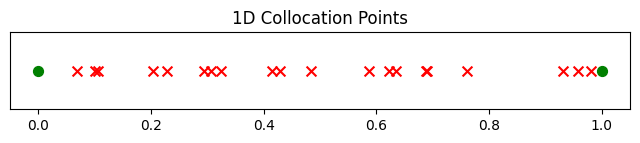

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 1))  # Width, Height
plt.scatter(x, np.zeros_like(x), color='red', s=50, marker='x', label='Collocation Points')
plt.scatter(x0, np.zeros_like(x0), color='green', s=50, label='Collocation Points')
plt.scatter(x1, np.zeros_like(x1), color='green', s=50, label='Collocation Points')
plt.yticks([])  # Hide y-axis as it's irrelevant in 1D
plt.gca().axes.get_yaxis().set_visible(False)  # Another way to hide y-axis elements
plt.title('1D Collocation Points')

In [8]:
# Provide bounday conditions
u_bc_0 = torch.tensor([[0.0]])  # boundary condition
u_bc_1 = torch.tensor([[0.0]])  # boundary condition

# compute the rhs
f = rhs_f(x)


**Step 5: Train the Neural Network**

In [9]:
model = PDE_Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5000

losses = []
losses_pde = []
losses_bcs = []


for epoch in range(num_epochs):
    x.requires_grad = True

    # predict in the interior part
    u_pred = model(x)
    loss_pde = eval_loss_pde(u_pred, x, f)

    # predict the initial condition
    u_pred_0 = model(x0)  # u(0)
    u_pred_1 = model(x1)  # u(1)

    loss_bc = eval_loss_bc(u_pred_0, u_pred_1, u_bc_0, u_bc_1)

    # add all loss componenets
    total_loss = loss_pde + loss_bc

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())
    losses_pde.append(loss_pde.item())
    losses_bcs.append(loss_bc.item())

    if (epoch+1) % 100 == 0:
        print ('Epoch [{:4d}/{:4d}], Total Loss: {:.4e}  PDE Loss: {:.4e}  BC Loss: {:.4e}'.format(
            epoch+1, num_epochs, total_loss.item(), loss_pde.item(), loss_bc.item()))


Epoch [ 100/10000], Total Loss: 4.3928e+01  PDE Loss: 4.1949e+01  BC Loss: 1.9795e+00
Epoch [ 200/10000], Total Loss: 6.9279e+00  PDE Loss: 1.0245e+00  BC Loss: 5.9034e+00
Epoch [ 300/10000], Total Loss: 5.3766e+00  PDE Loss: 4.1929e-01  BC Loss: 4.9573e+00
Epoch [ 400/10000], Total Loss: 4.7268e+00  PDE Loss: 2.8058e-01  BC Loss: 4.4462e+00
Epoch [ 500/10000], Total Loss: 4.2487e+00  PDE Loss: 2.3010e-01  BC Loss: 4.0186e+00
Epoch [ 600/10000], Total Loss: 3.8442e+00  PDE Loss: 2.0644e-01  BC Loss: 3.6378e+00
Epoch [ 700/10000], Total Loss: 3.4765e+00  PDE Loss: 1.9020e-01  BC Loss: 3.2863e+00
Epoch [ 800/10000], Total Loss: 3.1379e+00  PDE Loss: 1.7874e-01  BC Loss: 2.9591e+00
Epoch [ 900/10000], Total Loss: 2.8263e+00  PDE Loss: 1.7245e-01  BC Loss: 2.6538e+00
Epoch [1000/10000], Total Loss: 2.5406e+00  PDE Loss: 1.7232e-01  BC Loss: 2.3682e+00
Epoch [1100/10000], Total Loss: 2.2819e+00  PDE Loss: 1.7926e-01  BC Loss: 2.1027e+00
Epoch [1200/10000], Total Loss: 2.0522e+00  PDE Loss: 

**Step 6: Plotting the losses**

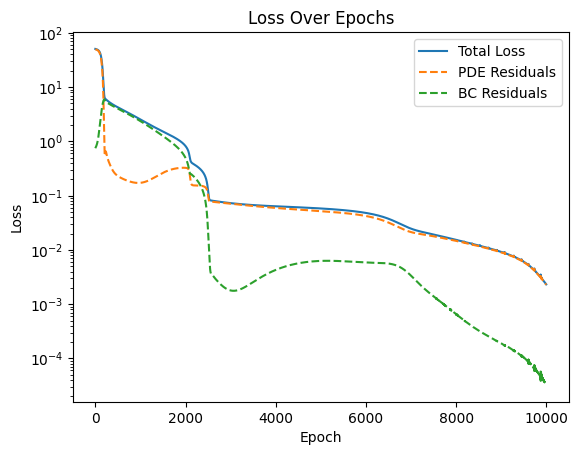

In [10]:
import matplotlib.pyplot as plt

plt.semilogy(losses, label='Total Loss')
plt.semilogy(losses_pde, label='PDE Residuals', linestyle='--')
plt.semilogy(losses_bcs, label='BC Residuals', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

**Step 7a: Evaluate the Solution on testing data**

After training, you can evaluate the model by comparing its predictions with the exact solution.


In [11]:
x_test = torch.linspace(0, 1, 100).unsqueeze(1)  # Evaluate from 0 to 1
u_pred = model(x_test).detach().numpy()
u_exact = analytical_u(x_test).detach().numpy()
print(type(u_pred))
print(type(u_pred))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


**Step 7b: Visualization the solution**

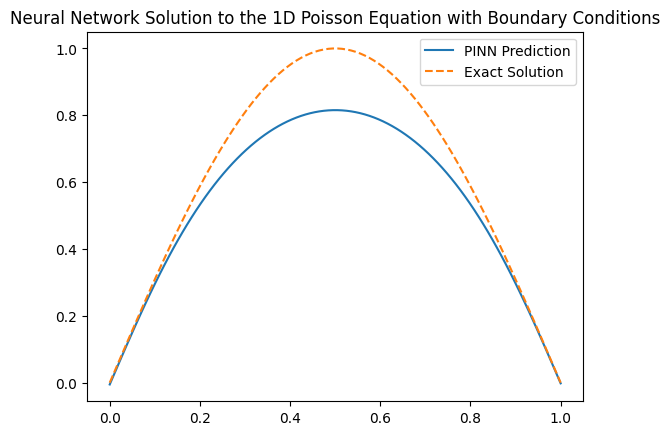

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(x_test.numpy(), u_pred, label='PINN Prediction')
plt.plot(x_test.numpy(), u_exact, label='Exact Solution', linestyle='--')
plt.legend()
plt.title('Neural Network Solution to the 1D Poisson Equation with Boundary Conditions')
plt.show()

**Step 7c: Plot the error**

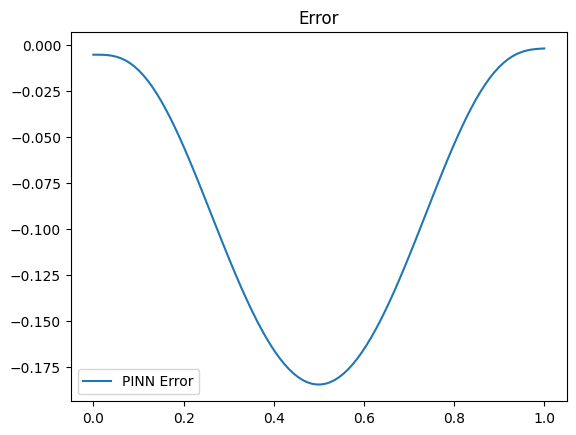

In [13]:
import numpy as np
error = (u_pred - u_exact)
plt.plot(x_test.numpy(), error, label='PINN Error')
plt.legend()
plt.title('Error')
plt.show()